In [83]:
%addpath --prepend ..
%reload skgym.policies.base skgym.policies.value_based skgym.value_functions.base skgym.value_functions.generic skgym.value_functions.predefined

from skgym.utils import one_hot_vector
from skgym.value_functions.predefined import LinearQ
from skgym.policies.value_based import ValuePolicy

env = gym.make('CartPole-v0')
s = env.reset()
a = env.action_space.sample()
s_next, r = env.step(a)[:2]
env.close()

q = LinearQ(env, model_type=1)
pi = ValuePolicy(q)
self = pi


A = np.array([a])
R = np.array([r])

if self.q.MODELTYPE == 1:
    print("model type: 1")
    n = env.action_space.n
    X = self.preprocess(s, a)
    Q = self.q.batch_eval(X)
    X_next = np.stack([self.preprocess(s_next, a_next) for a_next in range(n)])
    Q_next = self.q.batch_eval(X_next.reshape([-1, X_next.shape[2]])).reshape([n, -1])
    P = self.batch_eval(X_next)
elif self.q.MODELTYPE == 2:
    print("model type: 2")
    X = self.preprocess(s)
    Q = self.batch_eval(X, A)
    X_next = self.preprocess(s_next)
    Q_next = self.batch_eval(X_next)


print(P.shape, Q_next.shape)

Q_next = np.einsum('ij,ij->j', P, Q_next)

print(Q.shape, R.shape, Q_next.shape)



'..' already existed in sys.path, skipping
module reloaded: skgym.policies.base
module reloaded: skgym.policies.value_based
module reloaded: skgym.value_functions.base
module reloaded: skgym.value_functions.generic
module reloaded: skgym.value_functions.predefined
<class 'skgym.value_functions.predefined.LinearQ'>
model type: 1
(2, 1) (2, 1)
(1,) (1,) (1,)


C:\Users\krholshe\AppData\Roaming\Python\Python36\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [10]:
import skgym.value_functions.generic

In [282]:
%addpath --prepend ..
%reload skgym.utils
%reload skgym.value_functions.base skgym.value_functions.generic
%reload skgym.policies.base skgym.policies.value_based
%reload skgym.algorithms.base skgym.algorithms.td0

from sklearn.linear_model import SGDRegressor
from skgym.value_functions.generic import GenericV, GenericQ, GenericQTypeI, GenericQTypeII
from skgym.policies.value_based import ValueBasedPolicy
from skgym.algorithms.td0 import QLearning


    
env = gym.make('CartPole-v0')
s = env.reset()
a = env.action_space.sample()
s_next, r = env.step(a)[:2]
env.close()

# V = GenericV(env, SGDRegressor(eta0=0.9, power_t=0))
# V(s)


# Q = GenericQTypeI(env, SGDRegressor(eta0=0.9, power_t=0))
Q = GenericQTypeII(env, SGDRegressor(eta0=0.9, power_t=0))


P = ValueBasedPolicy(Q)


algo = QLearning(P)
X, A, R, X_next = algo.preprocess_transition(s, a, r, s_next)
Y = algo.Y(X, A, R, X_next)
print(Y, Q(s))



Q.update(X, Y)
print(P.proba(s).p)
print(P.value_function.regressor.estimators_[a].coef_)
print(P.value_function.regressor.estimators_[1-a].coef_)

Q(s)
P.proba(s).p
# P.random(), P.thompson(s), P.greedy(s)


'..' already existed in sys.path, skipping
module reloaded: skgym.utils
module reloaded: skgym.value_functions.base
module reloaded: skgym.value_functions.generic
module reloaded: skgym.policies.base
module reloaded: skgym.policies.value_based
module reloaded: skgym.algorithms.base
module reloaded: skgym.algorithms.td0
[0] [0] [1.]
[[1. 0.]] [0. 0.]
[0.71168577 0.28831423]
[-0.02289795  0.03282869 -0.02573561 -0.03102614]
[0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


array([0.71168577, 0.28831423])

In [91]:
%reload skgym.utils
from skgym.utils import ArrayDeque
from collections import deque

def print_info(d):
    print()
    print(f"d._idx        {d._idx}")
    print(f"d._len        {d._len}")
    print(f"d._array\n{d._array}\n")
    print(f"d.array\n{d.array}\n")
    print(f"d.array.shape {d.array.shape}")
    print()


print("d = ArrayDeque(shape=[], maxlen=3)")
d = ArrayDeque(shape=[1,2], maxlen=3)
print_info(d)

print("d.append([[10, 100]])")
d.append([[10, 100]])
print_info(d)

print("d.append([[20, 200]])")
d.append([[20, 200]])
print_info(d)

print("d.append([[30, 300]])")
d.append([[30, 300]])
print_info(d)

print("d.append([[40, 400]])")
d.append([[40, 400]])
print_info(d)

print("d.append([[50, 500]])")
d.append([[50, 500]])
print_info(d)

print("d.pop()  # 500")
d.pop()  # 500
print_info(d)

print("d.append([[60, 600]])")
d.append([[60, 600]])
print_info(d)

print("d.popleft()")
d.popleft()  # 300
print_info(d)


module reloaded: skgym.utils
d = ArrayDeque(shape=[], maxlen=3)

d._idx        2
d._len        0
d._array
[[[ 40. 400.]]

 [[ 60. 600.]]

 [[ 30. 300.]]]

start=0, end=0
d.array
[]

start=0, end=0
d.array.shape (0, 1, 2)

d.append([[10, 100]])

d._idx        0
d._len        1
d._array
[[[ 10. 100.]]

 [[ 60. 600.]]

 [[ 30. 300.]]]

start=0, end=1
d.array
[[[ 10. 100.]]]

start=0, end=1
d.array.shape (1, 1, 2)

d.append([[20, 200]])

d._idx        1
d._len        2
d._array
[[[ 10. 100.]]

 [[ 20. 200.]]

 [[ 30. 300.]]]

start=0, end=2
d.array
[[[ 10. 100.]]

 [[ 20. 200.]]]

start=0, end=2
d.array.shape (2, 1, 2)

d.append([[30, 300]])

d._idx        2
d._len        3
d._array
[[[ 10. 100.]]

 [[ 20. 200.]]

 [[ 30. 300.]]]

start=0, end=3
d.array
[[[ 10. 100.]]

 [[ 20. 200.]]

 [[ 30. 300.]]]

start=0, end=3
d.array.shape (3, 1, 2)

d.append([[40, 400]])

d._idx        0
d._len        3
d._array
[[[ 40. 400.]]

 [[ 20. 200.]]

 [[ 30. 300.]]]

start=1, end=4
d.array
[[[ 20. 200.]]


In [147]:
%reload skgym.algorithms.base skgym.algorithms.td0 skgym.value_functions.predefined
from skgym.algorithms.td0 import Sarsa
from skgym.value_functions.predefined import LinearQ

env = gym.make('CartPole-v0')
q = LinearQ(env, model_type=2)
algo = Sarsa(q)

# s = env.reset()
# a = env.action_space.sample()
# a_next = env.action_space.sample()
# s_next, r = env.step(a)[:2]
# env.close()

if q.MODELTYPE == 1:
    print(q.preprocess(s, a).shape)
else:
    print(q.preprocess(s).shape)

X, R, X_next = algo.preprocess_transition(s, a, r, s_next)

print(X.shape)

Q_next = algo.value_function.batch_eval(X_next)
algo.target(R, X_next, a_next)

module reloaded: skgym.algorithms.base
module reloaded: skgym.algorithms.td0
module reloaded: skgym.value_functions.predefined
(1, 8)
(1, 8)
R.shape=(1,), Q_next.shape=(1,)


/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


array([1.])

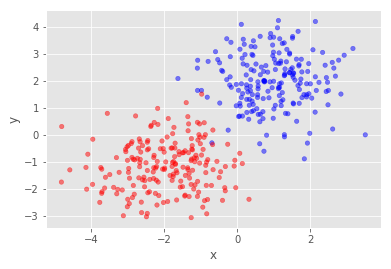

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdc00d5bef0>],
      dtype=object)

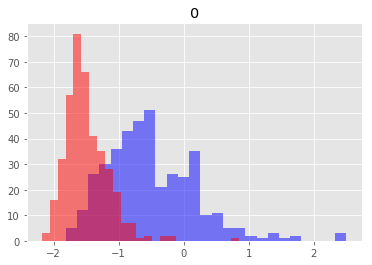

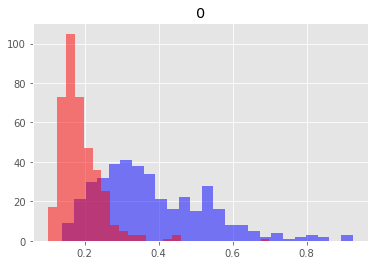

(array([1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 1., 0., 2., 1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.]),
 array([1.52387919, 1.53534196, 1.54680472, 1.55826749, 1.56973026,
        1.58119302, 1.59265579, 1.60411856, 1.61558132, 1.62704409,
        1.63850685, 1.64996962, 1.66143239, 1.67289515, 1.68435792,
        1.69582069, 1.70728345, 1.71874622, 1.73020899, 1.74167175,
        1.75313452, 1.76459729, 1.77606005, 1.78752282, 1.79898558,
        1.81044835, 1.82191112, 1.83337388, 1.84483665, 1.85629942,
        1.86776218, 1.87922495, 1.89068772, 1.90215048, 1.91361325,
        1.92507602, 1.93653878, 1.94800155, 1.95946431, 1.97092708,
      

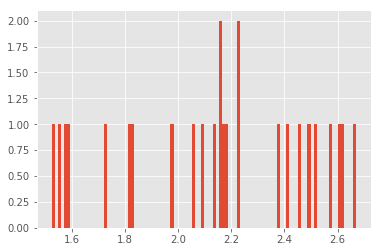

In [241]:
plt.hist(zs, bins=100)